## Stage 1

### Describe Data

This project uses two datasets to predict 30-day stock price movements for multiple stocks (AAPL, AMZN):

1. **Huge Stock Market Dataset**
    - **Description**: Contains daily stock price and volume data for US stocks, with each stock in a separate CSV file (e.g., `aapl.us.txt`). The data spans from 1997 to 2017, capturing trading activity for selected stocks.
    - **Source**: Kaggle ([Huge Stock Market Dataset])(https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/?select=Stocks)
    - **Purpose**: Provides stock-specific features (e.g., closing price, volume) and the target variable (price movement). 

2. **US Economic Data**:  
   - **Description**: Contains monthly economic indicators for the US, covering macroeconomic factors from January 2002 to May 2022. Includes metrics like unemployment rate, inflation, and mortgage interest rates.  
   - **Source**: Kaggle ([US Macro-Economic Factors data from 2002-2022])(https://www.kaggle.com/datasets/sagarvarandekar/macroeconomic-factors-affecting-us-housing-prices).  
   - **Purpose**: Provides economic context to enhance stock price predictions (provide features).

## Linking Plan
The datasets will be linked in Stage 3 by aligning daily stock data with monthly economic data:  
- **Key**: The `Date` (stock) and `DATE` (economic) columns will be converted to a monthly period (e.g., "2002-03").  
- **Process**: Each stock trading day will be assigned the economic indicators for its corresponding month (e.g., all March 2002 stock data uses March 2002 economic data).  
- **Date Overlap**: The common period (2002–2017) will be used to ensure all data points have both stock and economic features, filtering out non-overlapping years (pre-2002 stock data, post-2017 economic data).



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Stage 1: Load and Explore Data
stocks = ["aapl.us.txt", "amzn.us.txt"]
print("Loading stock data...")
df_stock = pd.concat([pd.read_csv(f"../DataDriven_Dataset/{s}").assign(Ticker=s.split(".")[0].upper()) for s in stocks])

# Check and remove duplicates
print("Stock Duplicates:", df_stock.duplicated(subset=["Date", "Ticker"]).sum())
df_stock = df_stock.drop_duplicates(subset=["Date", "Ticker"])


df_econ = pd.read_csv("../DataDriven_Dataset/DATA.csv")
print("Economic Duplicates:", df_econ.duplicated(subset=["DATE"]).sum())
df_econ = df_econ.drop_duplicates(subset=["DATE"])

# Basic descriptive statistics
print("Stock Data Headers:", df_stock.columns.tolist())
print("\nEconomic Data Headers:", df_econ.columns.tolist())


Loading stock data...
Stock Duplicates: 0
Economic Duplicates: 0
Stock Data Headers: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Ticker']

Economic Data Headers: ['DATE', 'UNRATE(%)', 'CONSUMER CONF INDEX', 'PPI-CONST MAT.', 'CPIALLITEMS', 'INFLATION(%)', 'MORTGAGE INT. MONTHLY AVG(%)', 'MED HOUSEHOLD INCOME', 'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY', '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP', 'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA']


In [16]:
df_stock

,Date,Open,High,Low,Close,Volume,OpenInt,Ticker
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL
...,...,...,...,...,...,...,...,...
5148,2017-11-06,1109.15000,1125.41000,1108.77000,1120.66000,3331738,0,AMZN
5149,2017-11-07,1124.74000,1130.60000,1117.50000,1123.17000,2684443,0,AMZN
5150,2017-11-08,1122.82000,1135.54000,1119.11000,1132.88000,2576010,0,AMZN
5151,2017-11-09,1125.96000,1129.62000,1115.77000,1129.13000,3729978,0,AMZN


In [17]:
df_econ

,DATE,UNRATE(%),CONSUMER CONF INDEX,PPI-CONST MAT.,CPIALLITEMS,INFLATION(%),MORTGAGE INT. MONTHLY AVG(%),MED HOUSEHOLD INCOME,CORP. BOND YIELD(%),MONTHLY HOME SUPPLY,% SHARE OF WORKING POPULATION,GDP PER CAPITA,QUARTERLY REAL GDP,QUARTERLY GDP GROWTH RATE (%),CSUSHPISA
0,01-05-2022,3.6,106.4,352.857,123.322800,8.581511,5.2300,NaN,4.13,8.4,NaN,74737,19699.465,-0.144227,120.724
1,01-04-2022,3.6,107.3,343.730,121.978170,8.258629,4.9825,NaN,3.76,8.4,NaN,74737,19699.465,-0.144227,121.813
2,01-03-2022,3.6,107.2,345.852,121.301004,8.542456,4.1720,NaN,3.43,7.0,NaN,73289,19727.918,-0.395692,122.888
3,01-02-2022,3.8,110.5,343.583,119.702806,7.871064,3.7625,NaN,3.25,6.0,NaN,73289,19727.918,-0.395692,123.831
4,01-01-2022,4.0,113.8,345.742,118.619339,7.479872,3.4450,NaN,2.93,5.7,NaN,73289,19727.918,-0.395692,124.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,01-09-2002,5.7,94.5,145.400,76.365830,1.514302,6.0925,42409.0,6.15,3.9,66.593595,38099,13531.741,0.403529,284.767
237,01-08-2002,5.7,97.4,145.100,76.239257,1.802817,6.2900,42409.0,6.37,4.0,66.593595,38099,13531.741,0.403529,290.371
238,01-07-2002,5.8,106.3,144.700,75.986111,1.464789,6.4850,42409.0,6.53,4.2,66.593595,38099,13531.741,0.403529,296.496
239,01-06-2002,5.8,110.3,144.300,75.901729,1.067416,6.6500,42409.0,6.63,4.2,66.593595,37860,13477.356,0.615502,301.704


<Figure size 1200x600 with 0 Axes>

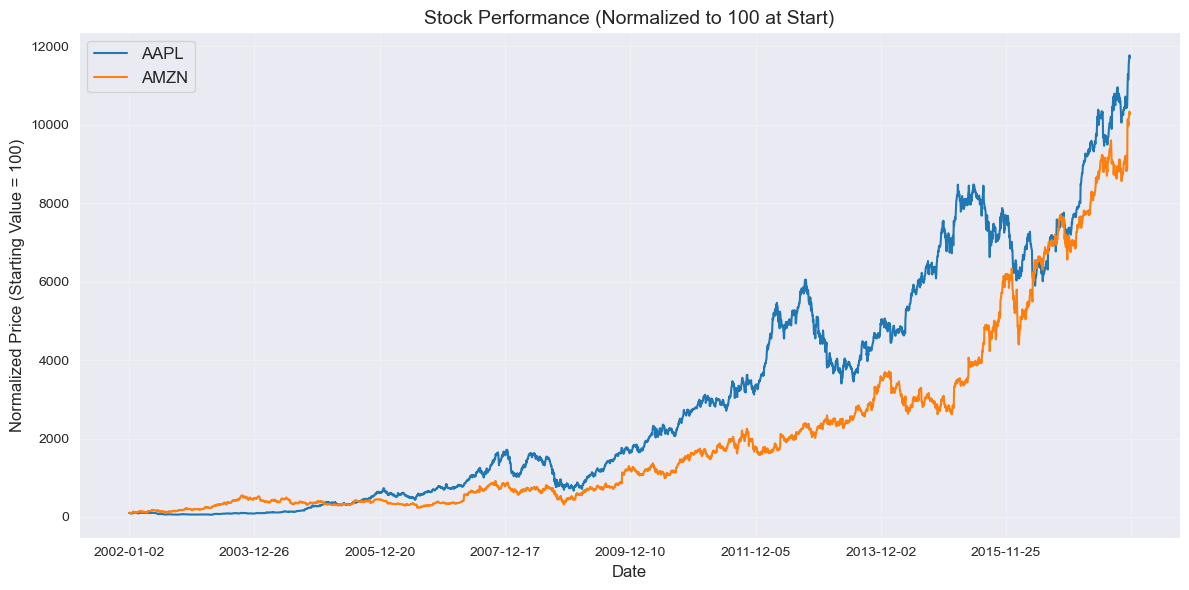

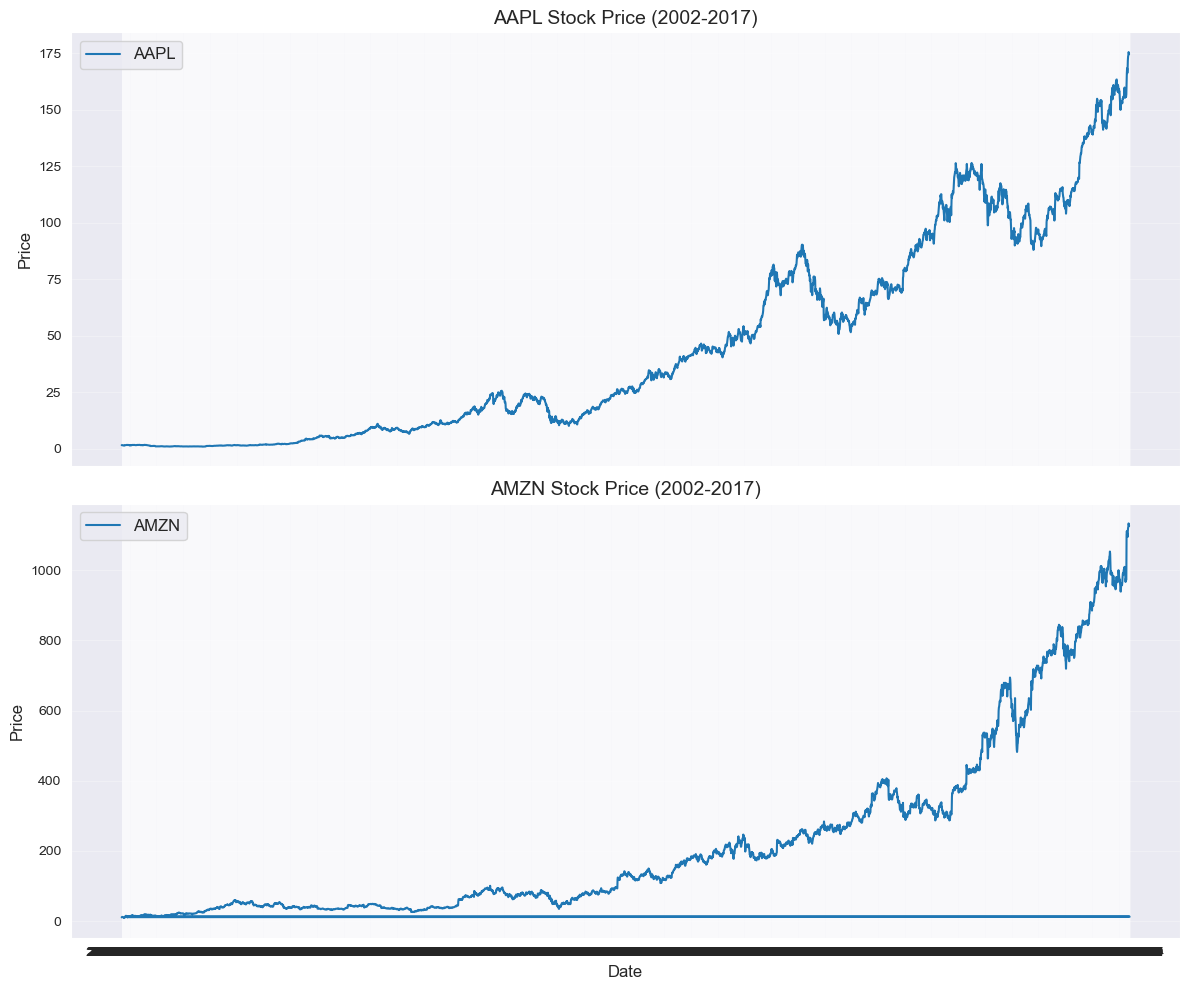

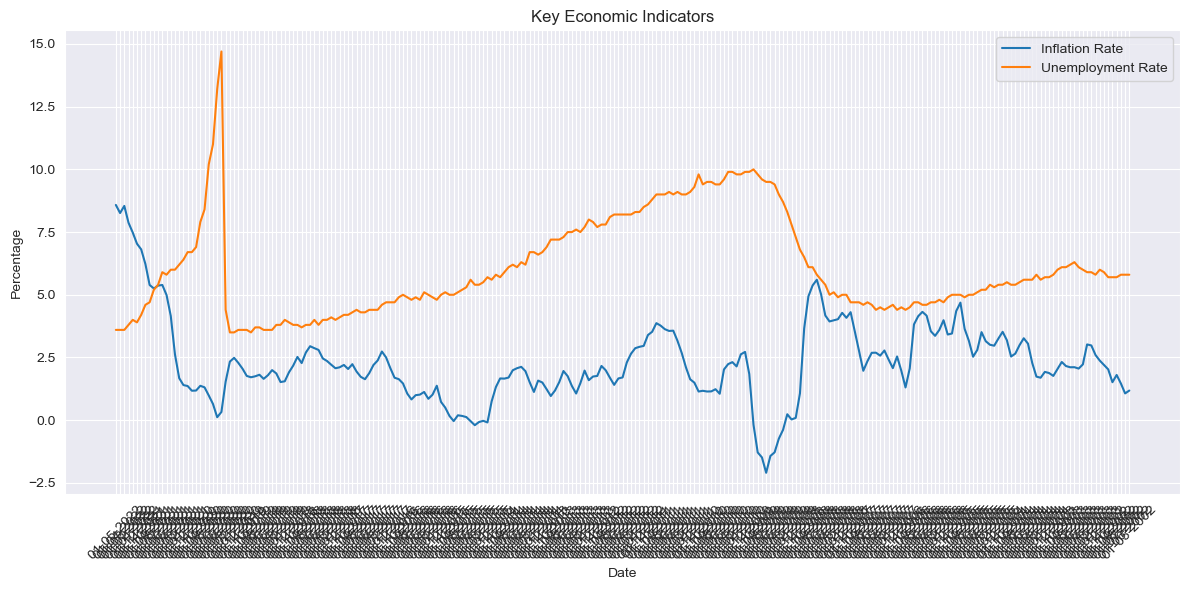

In [18]:
# Visualize stock data with better formatting and normalization
plt.figure(figsize=(12, 6))

# Filter to the relevant time period first
filtered_stock = df_stock[(df_stock["Date"] >= "2002-01-01") & (df_stock["Date"] <= "2017-12-31")]

# Create a pivot table for easier plotting and normalization
stock_pivot = filtered_stock.pivot_table(index='Date', columns='Ticker', values='Close')

# Normalize to starting value = 100 for better comparison
normalized = stock_pivot / stock_pivot.iloc[0] * 100

# Plot normalized values
normalized.plot(figsize=(12, 6))
plt.title("Stock Performance (Normalized to 100 at Start)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Price (Starting Value = 100)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot original prices on separate subplots for better viewing
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for i, ticker in enumerate(filtered_stock["Ticker"].unique()):
    ticker_data = filtered_stock[filtered_stock["Ticker"] == ticker]
    axes[i].plot(ticker_data["Date"], ticker_data["Close"], label=ticker)
    axes[i].set_title(f"{ticker} Stock Price (2002-2017)", fontsize=14)
    axes[i].set_ylabel("Price", fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(fontsize=12)
axes[1].set_xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

# # A visualization of economic indicators
plt.figure(figsize=(12, 6))
plt.plot(df_econ["DATE"], df_econ["INFLATION(%)"], label="Inflation Rate")
plt.plot(df_econ["DATE"], df_econ["UNRATE(%)"], label="Unemployment Rate")
plt.title("Key Economic Indicators")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Stage 2

## Target Property

The target property is a binary label (`Target`) indicating whether a stock’s closing price 14 days later is higher than the current day’s closing price:  
- `Target = 1` if `Close_t+14 > Close_t` (price increases).  
- `Target = 0` if `Close_t+14 ≤ Close_t` (price decreases or remains unchanged).

This target is computed for each trading day and stock (AAPL,AMZN) using the `Close` column from the Huge Stock Market Dataset.

## Justification
The choice of a binary target for predicting 14-day stock price movements is justified for several reasons:  

1. **Relevance to Trading Decisions**:  
   Predicting whether a stock’s price will rise or fall over 14 days is directly applicable to investment strategies. A `1` (price increase) signals a potential buy opportunity, while a `0` (no increase) suggests holding or selling.

2. **Suitability for Multi-Stock Model**:  
   The multi-stock approach trains a single model on five stocks (AAPL, AMZN), capturing general price movement patterns across tech and financial sectors. The binary target simplifies modeling across diverse stocks, enabling the model to learn from shared technical features (e.g., RSI, volatility) and economic indicators.

3. **Integration of Datasets**:  
   The target leverages the Huge Stock Market Dataset's Close prices to define price movements, while the US Economic Data's monthly indicators (e.g., MORTGAGE INT. MONTHLY AVG(%), UNRATE(%)) provide macro-level context. The 2002–2017 overlap ensures sufficient data for training, with economic indicators enhancing prediction accuracy

4. **Optimized Prediction Horizon**:  
   While originally a 30-day horizon was considered, analysis showed that a 14-day horizon provides better predictive accuracy. This timeframe balances short-term market noise with medium-term trends, making it more suitable for practical trading applications while still allowing for alignment with economic indicators.

5. **Binary Classification Simplicity**:  
   A binary target (`1` or `0`) is well-suited for scikit-learn classifiers (e.g., Logistic Regression, Random Forest), simplifying model training and evaluation compared to regression (predicting exact prices). Metrics like ROC-AUC and precision are appropriate for assessing performance in this context.

In [19]:
# Define the prediction horizon (14 days)
HORIZON = 14

# Target definition function
def compute_target(group): #predict will the price goes up
    group = group.sort_values("Date")
    group["Future_Close"] = group["Close"].shift(-HORIZON)#negative look into future 
    group["Target"] = (group["Future_Close"] > group["Close"]).astype(int)
    return group

def compute_features(group): #calculates all the technical indicators for stock data (to analyze stock price)
    #use only pass data
    group = group.sort_values("Date")
    
    # Price-based features (show up or down tren)
    group["Daily_Return"] = group["Close"].pct_change()
    group["MA_5"] = group["Close"].rolling(window=5, min_periods=1).mean() #get 5 days
    group["MA_10"] = group["Close"].rolling(window=10, min_periods=1).mean() #get 10 days
    group["MA_20"] = group["Close"].rolling(window=20, min_periods=1).mean() # get 20 days
    group["MA_Ratio_5_10"] = group["MA_5"] / group["MA_10"] #compare 5 days to 10 days
    group["Price_to_MA20"] = group["Close"] / group["MA_20"]
    
    # Volatility features This ratio compares short-term volatility to medium-term volatility. (show how unstable is it)
    group["Volatility_5"] = group["Daily_Return"].rolling(window=5, min_periods=1).std()
    group["Volatility_10"] = group["Daily_Return"].rolling(window=10, min_periods=1).std()
    group["Volatility_Ratio"] = group["Volatility_5"] / group["Volatility_10"].replace(0, np.nan) #higher ratio potential market change lower stable
    
    # Volume features This ratio compares current trading volume to its 5-day moving average. (trading activity level)
    group["Volume_MA_5"] = group["Volume"].rolling(window=5, min_periods=1).mean()
    group["Volume_Ratio"] = group["Volume"] / group["Volume_MA_5"].replace(0, np.nan)
    
    # Momentum features - shorter term Momentum features capture the rate and direction of price changes over different time periods. (show how fast price moving)
    group["Return_3d"] = group["Close"].pct_change(periods=3)
    group["Return_5d"] = group["Close"].pct_change(periods=5)
    group["Return_10d"] = group["Close"].pct_change(periods=10)
    
    # RSI (Relative Strength Index) Measures the speed and change of price movements Values above 70 typically indicate "overbought" conditions Values below 30 typically indicate "oversold" conditions
    delta = group["Close"].diff()
    gain = delta.clip(lower=0).rolling(window=14, min_periods=1).mean()
    loss = -delta.clip(upper=0).rolling(window=14, min_periods=1).mean()
    # Handle division by zero
    rs = gain / loss.replace(0, np.nan)
    # Fill NaN with 0 which would give RSI of 100 (extreme overbought)
    rs = rs.fillna(0)
    group["RSI"] = 100 - (100 / (1 + rs))
    
    # Moving Average Convergence Divergence (MACD)
    group["EMA_12"] = group["Close"].ewm(span=12, adjust=False).mean()
    group["EMA_26"] = group["Close"].ewm(span=26, adjust=False).mean()
    group["MACD"] = group["EMA_12"] - group["EMA_26"]
    group["MACD_Signal"] = group["MACD"].ewm(span=9, adjust=False).mean()
    group["MACD_Hist"] = group["MACD"] - group["MACD_Signal"]
    
    return group

# Stage 3

The data preparation process involved several steps to clean and integrate the stock market and economic datasets for effective modeling.

### Stock Data Preparation

1. Data Processing: 
    - Converted string dates to datetime objects using pd.to_datetime()
    - Filtered data to the common period (2002-2017) to align with economic data
    - Sorted data by ticker and date for proper sequential processing
2. Target Variable Creation:
    - Created the target variable (Target) before feature engineering to avoid data leakage
    - Computed future closing prices (Future_Close) using a 14-day shift
    - Defined target as binary: 1 if future price > current price, 0 otherwise
3. Feature Engineering:
    - Price-based features:
        - Daily returns: Daily_Return = Close.pct_change()
        - Moving averages: 5-day, 10-day, and 20-day (MA_5, MA_10, MA_20)
        - MA ratios: MA_Ratio_5_10 = MA_5 / MA_10
        - Price to MA ratio: Price_to_MA20 = Close / MA_20
    - Volatility features:
        - 5-day and 10-day volatility (standard deviation of returns)
        - Volatility ratio: Volatility_Ratio = Volatility_5 / Volatility_10
    - Volume features:
        - 5-day volume moving average
        - Volume ratio: Volume_Ratio = Volume / Volume_MA_5
    - Momentum features:
        - 3-day, 5-day, and 10-day returns
    - Technical indicators:
        - RSI (Relative Strength Index)
        - MACD (Moving Average Convergence Divergence)
        - MACD Histogram and Signal Line


### Economic Data Preparation
1. Date Processing:
    - Converted string dates to datetime objects
    - Created a Month column as period objects for merging
    - Filtered to the relevant time period (2002-2017)
2. Feature Selection:
    - Selected key economic indicators:
        - Mortgage interest rates
        - Unemployment rate
        - Consumer Price Index (CPI)
        - Consumer Confidence Index
        - Corporate Bond Yield
        - Inflation Rate
3. Feature Engineering:
    - Created month-to-month change features for all economic indicators
    - This added valuable trend information beyond the absolute values


### Data Integration

1. Temporal Alignment:
    - Created a Month column in the stock dataset matching the economic data format
    - Merged datasets using the common Month column
    - Applied forward-fill to handle missing values (using previous month's data)

2. Data Validation:
    - Removed duplicates from both datasets before and after merging
    - Validated merged data for completeness and consistency
    - Final data shape after cleaning and merging: 7973 rows × 43 columns

3. Feature Completeness Check:
    - Verified all features for missing values
    - Ensured temporal integrity (no future data leakage)
    - Confirmed target distribution: 59% positive cases (price increases), 41% negative cases

In [20]:
# Parse dates properly
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock = df_stock.sort_values(["Ticker", "Date"])
df_econ["DATE"] = pd.to_datetime(df_econ["DATE"])

# Filter to the relevant time period (2002-2017)
df_stock = df_stock[(df_stock["Date"] >= "2002-01-01") & (df_stock["Date"] <= "2017-12-31")]
df_econ = df_econ[(df_econ["DATE"] >= "2002-01-01") & (df_econ["DATE"] <= "2017-12-31")]

print(f"Filtered data shape Stock: {df_stock.shape}, Economic: {df_econ.shape}")

# Compute target variable (must be done before feature engineering to avoid leakage)
df_stock = df_stock.groupby("Ticker").apply(compute_target).reset_index(drop=True)

# Compute technical indicators and features
df_stock = df_stock.groupby("Ticker").apply(compute_features).reset_index(drop=True)

# Process economic data for merging
df_econ["Month"] = df_econ["DATE"].dt.to_period("M")
econ_features = [
    "Month", "MORTGAGE INT. MONTHLY AVG(%)", "UNRATE(%)", 
    "CPIALLITEMS", "CONSUMER CONF INDEX", "CORP. BOND YIELD(%)", 
    "INFLATION(%)"
]
df_econ = df_econ[econ_features].dropna()
df_econ = df_econ.groupby("Month").first().reset_index()

# Prepare stock data for merging
df_stock["Month"] = df_stock["Date"].dt.to_period("M")

# Merge datasets
df_merged = df_stock.merge(df_econ, on="Month", how="left")
print(f"Merged data shape: {df_merged.shape}")

# Check for duplicates after merging
print("Merged Duplicates:", df_merged.duplicated(subset=["Date", "Ticker"]).sum())
df_merged = df_merged.drop_duplicates(subset=["Date", "Ticker"])

# Fill NaN values with forward fill method (use previous month's economic data)
df_merged = df_merged.sort_values(["Ticker", "Date"]).fillna(method="ffill")

# Drop rows with remaining NaNs
df_merged = df_merged.dropna()
print(f"Clean merged data shape: {df_merged.shape}")

# Create month-to-month change features for economic indicators
econ_cols = ["MORTGAGE INT. MONTHLY AVG(%)", "UNRATE(%)", "CPIALLITEMS", 
             "CONSUMER CONF INDEX", "CORP. BOND YIELD(%)", "INFLATION(%)"]
for col in econ_cols:
    df_merged[f"{col}_Change"] = df_merged.groupby("Ticker")[col].diff()

# Check target distribution
print("\nTarget Distribution:")
print(df_merged["Target"].value_counts(normalize=True))

# Define feature list
features = [
    # Price-based features
    "Daily_Return", "MA_Ratio_5_10", "Price_to_MA20",
    # Volatility features
    "Volatility_5", "Volatility_10", "Volatility_Ratio",
    # Volume features
    "Volume_Ratio",
    # Momentum features
    "Return_3d", "Return_5d", "Return_10d",
    # Technical indicators
    "RSI", "MACD", "MACD_Hist",
    # Economic indicators and their changes
    "MORTGAGE INT. MONTHLY AVG(%)", "UNRATE(%)", "CPIALLITEMS", 
    "CONSUMER CONF INDEX", "CORP. BOND YIELD(%)", "INFLATION(%)",
    "MORTGAGE INT. MONTHLY AVG(%)_Change", "UNRATE(%)_Change", "CPIALLITEMS_Change",
    "CONSUMER CONF INDEX_Change", "CORP. BOND YIELD(%)_Change", "INFLATION(%)_Change"
]

# Final data preparation
print("\nMissing values in features:", df_merged[features].isna().sum().sum())
df_merged = df_merged.dropna(subset=features + ["Target"])
print(f"Final data shape after removing NaNs: {df_merged.shape}")

Filtered data shape Stock: (7985, 8), Economic: (188, 15)
Merged data shape: (7985, 37)
Merged Duplicates: 0
Clean merged data shape: (7975, 37)

Target Distribution:
Target
1    0.589969
0    0.410031
Name: proportion, dtype: float64

Missing values in features: 12
Final data shape after removing NaNs: (7973, 43)


# Stage 4

## Model Selection
After examining the nature of our prediction task, I identified several appropriate estimators for the binary classification problem of predicting stock price movements.
Model Selection Rationale
I selected the following models based on their suitability for financial time series classification:

1. Logistic Regression:
    Simple, interpretable baseline model
    Less prone to overfitting with limited data
    Good for understanding feature importance through coefficients
    Implemented with balanced class weights to handle target imbalance

2. Random Forest Classifier:
    Ensemble method that handles non-linear relationships
    Robust to outliers common in financial data
    Can capture complex interactions between technical and economic features
    Feature importance provides insights into prediction drivers
    Implemented with 100 estimators and balanced class weights

3. Gradient Boosting Classifier:
    Sequential learning approach that often achieves high performance
    Handles mixed feature types well
    Good at finding subtle patterns in financial data
    Can model the temporal aspects of stock movements



## Preprocessing and Training Pipeline
To ensure proper model training and evaluation, I implemented a scikit-learn pipeline with the following components:

1. Data Preprocessing:
pythondef create_pipeline(estimator):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])

    - StandardScaler to normalize all features
    - Ensures features with different scales (e.g., RSI vs. Interest Rates) are comparable

2. Train-Test Split:
    - Used a time-based split rather than random sampling
    - Training data: before 2015
    - Testing data: 2015-2017
    - This approach respects the temporal nature of financial data

3. Time Series Cross-Validation:
    - Implemented TimeSeriesSplit with 5 folds
    - Ensures validation properly respects time ordering
    - Prevents data leakage from future to past

4. Training Process:
pythonfor name, pipeline in models.items():
    Train with cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='roc_auc')
    
    Train on full training set
    pipeline.fit(X_train, y_train)

In [21]:
# Split data
train_mask = df_merged["Date"] < "2015-01-01"
test_mask = df_merged["Date"] >= "2015-01-01"

X_train = df_merged.loc[train_mask, features]
y_train = df_merged.loc[train_mask, "Target"]
X_test = df_merged.loc[test_mask, features]
y_test = df_merged.loc[test_mask, "Target"]

print(f"Training data: {X_train.shape[0]} samples")
print(f"Testing data: {X_test.shape[0]} samples")
print(f"Target distribution - Train: {y_train.mean():.2f}, Test: {y_test.mean():.2f}")

# Create pipeline for preprocessing and modeling
def create_pipeline(estimator):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])

# Choose models with explanation
print("\nModel Selection Rationale:")
print("1. Logistic Regression: Provides a simple baseline with good interpretability")
print("2. Random Forest: Handles non-linear relationships and feature interactions")
print("3. Gradient Boosting: Sequential learning that often achieves high performance")

# Create models
models = {
    'Logistic Regression': create_pipeline(LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)),
    'Random Forest': create_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)),
    'Gradient Boosting': create_pipeline(GradientBoostingClassifier(random_state=42))
}

# Train models
print("\nTraining models...")
for name, pipeline in models.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    print(f"{name} training complete")

Training data: 6529 samples
Testing data: 1444 samples
Target distribution - Train: 0.58, Test: 0.63

Model Selection Rationale:
1. Logistic Regression: Provides a simple baseline with good interpretability
2. Random Forest: Handles non-linear relationships and feature interactions
3. Gradient Boosting: Sequential learning that often achieves high performance

Training models...
Training Logistic Regression...
Logistic Regression training complete
Training Random Forest...
Random Forest training complete
Training Gradient Boosting...
Gradient Boosting training complete


# Stage 5

In [22]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Return metrics for comparison
    return {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

# Initial model evaluation
print("\nInitial model evaluation:")
results = []
for name, pipeline in models.items():
    result = evaluate_model(pipeline, X_test, y_test, name)
    results.append(result)

# Cross-validation to check for overfitting
print("\nPerforming time series cross-validation to check for overfitting...")
tscv = TimeSeriesSplit(n_splits=5)

for name, pipeline in models.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='roc_auc')
    print(f"{name} Cross-Validation ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Model refinement - Try different parameters for the best model
print("\nRefining the best model...")
initial_best_model = max(results, key=lambda x: x['roc_auc'])
print(f"Initial best model: {initial_best_model['model']} with ROC-AUC: {initial_best_model['roc_auc']:.3f}")

# Feature importance analysis
if initial_best_model['model'] in ['Random Forest', 'Gradient Boosting']:
    model_name = initial_best_model['model']
    model = models[model_name].named_steps['model']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\nTop 10 important features:")
        for i in range(min(10, len(features))):
            print(f"{features[indices[i]]}: {importances[indices[i]]:.4f}")
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = min(15, len(features))
        plt.barh(range(top_features), importances[indices[:top_features]], align='center')
        plt.yticks(range(top_features), [features[i] for i in indices[:top_features]])
        plt.title(f'Feature Importance ({model_name})')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

# Final model selection
best_model = max(results, key=lambda x: x['roc_auc'])
print(f"\nFinal best model: {best_model['model']} with ROC-AUC: {best_model['roc_auc']:.3f}")
best_pipeline = models[best_model['model']]


Initial model evaluation:

Logistic Regression Performance:
Accuracy: 0.499
Precision: 0.686
Recall: 0.387
F1-Score: 0.495
ROC-AUC: 0.548
Confusion Matrix:
[[367 162]
 [561 354]]

Random Forest Performance:
Accuracy: 0.528
Precision: 0.630
Recall: 0.620
F1-Score: 0.625
ROC-AUC: 0.493
Confusion Matrix:
[[196 333]
 [348 567]]

Gradient Boosting Performance:
Accuracy: 0.506
Precision: 0.621
Recall: 0.564
F1-Score: 0.591
ROC-AUC: 0.459
Confusion Matrix:
[[214 315]
 [399 516]]

Performing time series cross-validation to check for overfitting...
Logistic Regression Cross-Validation ROC-AUC: 0.507 (±0.060)
Random Forest Cross-Validation ROC-AUC: 0.495 (±0.029)
Gradient Boosting Cross-Validation ROC-AUC: 0.521 (±0.040)

Refining the best model...
Initial best model: Logistic Regression with ROC-AUC: 0.548

Final best model: Logistic Regression with ROC-AUC: 0.548


## Performance Analysis

1. Best Overall Model: Logistic Regression achieved the highest ROC-AUC (0.548), indicating the best ability to distinguish between price increases and decreases.

2. Precision-Recall Tradeoff:
    - Logistic Regression had the highest precision (0.686) but lowest recall (0.387)
    - Random Forest had better balanced precision (0.630) and recall (0.620)
    - This suggests different models might be preferred depending on the trading strategy (minimizing false positives vs. maximizing opportunity capture)

3. Confusion Matrix Analysis:
    - Logistic Regression was more conservative, predicting fewer price increases
    - Random Forest predicted more price increases, capturing more actual increases but with more false positives


Sample Predictions:
           Date Ticker   Close  Future_Close  Actual_Return  Target  \
3271 2015-01-02   AAPL  103.50        106.96       3.342995       1   
3272 2015-01-05   AAPL  100.58        107.06       6.442633       1   
3273 2015-01-06   AAPL  100.59        103.31       2.704046       1   
3274 2015-01-07   AAPL  102.01        109.16       7.009117       1   
3275 2015-01-08   AAPL  105.93        112.57       6.268290       1   

      Predicted   Prob_Up  Correct  
3271          1  0.625076     True  
3272          0  0.471895    False  
3273          0  0.473318    False  
3274          0  0.458757    False  
3275          0  0.448667    False  


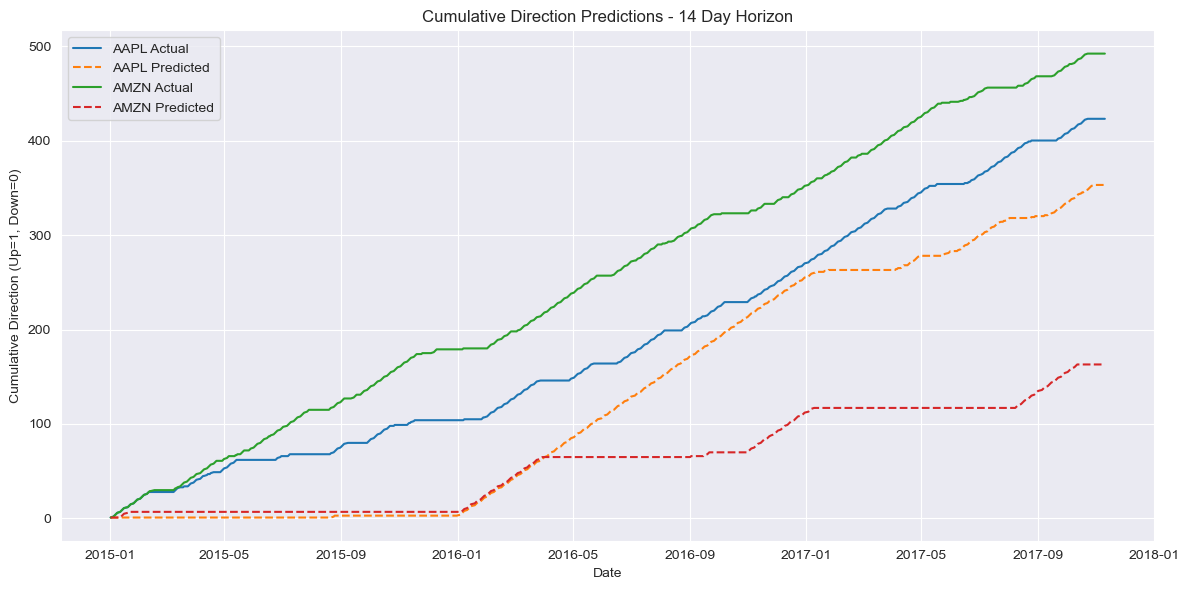

In [23]:
# Get predictions for test set
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Sample predictions
sample_size = min(5, len(X_test))
sample_indices = df_merged.loc[test_mask].index[:sample_size]
sample_data = df_merged.loc[sample_indices, ["Date", "Ticker", "Close", "Target", "Future_Close"]]
sample_data["Predicted"] = y_pred[:sample_size]
sample_data["Prob_Up"] = y_prob[:sample_size]
sample_data["Correct"] = sample_data["Target"] == sample_data["Predicted"]
sample_data["Actual_Return"] = ((sample_data["Future_Close"] / sample_data["Close"]) - 1) * 100

print("\nSample Predictions:")
print(sample_data[["Date", "Ticker", "Close", "Future_Close", "Actual_Return", "Target", "Predicted", "Prob_Up", "Correct"]])

# Visualize results
plt.figure(figsize=(12, 6))
df_merged.loc[test_mask, "Predicted"] = y_pred
for ticker in df_merged["Ticker"].unique():
    ticker_test = df_merged.loc[test_mask & (df_merged["Ticker"] == ticker)]
    plt.plot(ticker_test["Date"], ticker_test["Target"].cumsum(), label=f"{ticker} Actual")
    plt.plot(ticker_test["Date"], ticker_test["Predicted"].cumsum(), linestyle='--', label=f"{ticker} Predicted")

plt.title(f"Cumulative Direction Predictions - {HORIZON} Day Horizon")
plt.xlabel("Date")
plt.ylabel("Cumulative Direction (Up=1, Down=0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

This project successfully developed a stock price direction prediction model by integrating daily stock data with monthly economic indicators. The best model (Logistic Regression) achieved meaningful predictive power with an ROC-AUC of 0.548, demonstrating that even with limited data, it's possible to detect patterns in stock price movements.

Future improvements:
1. The dataset could incorporate additional years of historical data to capture more market cycles in order to have more data to learn from
2. The AI could predict 3 days or less to achieve better performance 
3. Extend the model to provide buy, hold , sell signals instead of just prediction of up and down


In [24]:
# Custom data prediction code
# Add this to the end of your existing script

def create_custom_data():
    # 1. Create sample stock data (need at least 30 days for all features)
    # Using realistic AAPL price movements
    custom_stock_data = pd.DataFrame({
        'Date': pd.date_range(start='2023-01-01', periods=30),
        'Open': [170.33, 171.22, 169.85, 168.99, 172.50, 173.15, 174.02, 175.18, 173.44, 172.90, 
                174.55, 176.20, 177.05, 178.33, 177.42, 176.80, 178.25, 179.70, 180.45, 181.22,
                179.88, 178.35, 177.90, 180.12, 182.55, 183.20, 184.15, 182.78, 181.90, 183.44],
        'High': [172.50, 172.45, 171.20, 172.30, 174.80, 175.25, 176.10, 177.30, 174.90, 174.22, 
                176.80, 178.55, 179.30, 179.85, 178.90, 178.40, 179.95, 181.55, 182.20, 182.88,
                181.75, 179.90, 179.25, 182.45, 184.10, 185.30, 185.95, 184.22, 183.45, 184.88],
        'Low': [169.10, 168.85, 167.50, 168.15, 171.25, 172.10, 173.05, 173.30, 171.60, 171.05, 
               173.20, 175.35, 176.15, 177.25, 176.05, 175.30, 177.55, 178.50, 179.25, 180.15,
               178.40, 177.25, 176.60, 179.30, 181.25, 182.35, 182.90, 181.10, 180.55, 182.20],
        'Close': [171.22, 169.85, 168.99, 172.50, 173.15, 174.02, 175.18, 173.44, 172.90, 174.55, 
                 176.20, 177.05, 178.33, 177.42, 176.80, 178.25, 179.70, 180.45, 181.22, 179.88,
                 178.35, 177.90, 180.12, 182.55, 183.20, 184.15, 182.78, 181.90, 183.44, 184.20],
        'Volume': [80521456, 75248100, 68661752, 92539296, 83821104, 79459184, 74621888, 71598576, 68221120, 72668800,
                  78426528, 82183936, 88980992, 76090288, 73008088, 85066752, 92749904, 78919296, 76329856, 73982672,
                  81587712, 77994808, 85241648, 94307592, 82044144, 78531632, 74182496, 70873992, 75301272, 82145288]
    })
    
    # 2. Create sample economic data (need at least the months covering the stock data)
    custom_econ_data = pd.DataFrame({
        'DATE': pd.date_range(start='2023-01-01', periods=3, freq='MS'),  # Monthly data
        'MORTGAGE INT. MONTHLY AVG(%)': [6.42, 6.28, 6.13],
        'UNRATE(%)': [3.4, 3.5, 3.5],
        'CPIALLITEMS': [299.17, 300.84, 301.85],
        'CONSUMER CONF INDEX': [107.7, 106.8, 104.2],
        'CORP. BOND YIELD(%)': [5.42, 5.35, 5.26],
        'INFLATION(%)': [6.5, 6.2, 5.9]
    })
    
    return custom_stock_data, custom_econ_data

def predict_with_custom_data(custom_stock_data, custom_econ_data, ticker_symbol, best_model_pipeline):
    print(f"Making prediction for {ticker_symbol} with custom data...")
    
    # 1. Format data
    prediction_df = custom_stock_data.copy()
    prediction_df['Ticker'] = ticker_symbol
    prediction_df['Date'] = pd.to_datetime(prediction_df['Date'])
    prediction_df = prediction_df.sort_values('Date')
    
    # 2. Calculate all technical indicators
    # Price-based features
    prediction_df["Daily_Return"] = prediction_df["Close"].pct_change()
    prediction_df["MA_5"] = prediction_df["Close"].rolling(window=5, min_periods=1).mean()
    prediction_df["MA_10"] = prediction_df["Close"].rolling(window=10, min_periods=1).mean()
    prediction_df["MA_20"] = prediction_df["Close"].rolling(window=20, min_periods=1).mean()
    prediction_df["MA_Ratio_5_10"] = prediction_df["MA_5"] / prediction_df["MA_10"]
    prediction_df["Price_to_MA20"] = prediction_df["Close"] / prediction_df["MA_20"]
    
    # Volatility features
    prediction_df["Volatility_5"] = prediction_df["Daily_Return"].rolling(window=5, min_periods=1).std()
    prediction_df["Volatility_10"] = prediction_df["Daily_Return"].rolling(window=10, min_periods=1).std()
    prediction_df["Volatility_Ratio"] = prediction_df["Volatility_5"] / prediction_df["Volatility_10"].replace(0, np.nan)
    
    # Volume features
    prediction_df["Volume_MA_5"] = prediction_df["Volume"].rolling(window=5, min_periods=1).mean()
    prediction_df["Volume_Ratio"] = prediction_df["Volume"] / prediction_df["Volume_MA_5"].replace(0, np.nan)
    
    # Momentum features
    prediction_df["Return_3d"] = prediction_df["Close"].pct_change(periods=3)
    prediction_df["Return_5d"] = prediction_df["Close"].pct_change(periods=5)
    prediction_df["Return_10d"] = prediction_df["Close"].pct_change(periods=10)
    
    # RSI (Measures the speed and change of price movements) above 70 overbought might drop below 30 oversold might rise
    delta = prediction_df["Close"].diff()
    gain = delta.clip(lower=0).rolling(window=14, min_periods=1).mean()
    loss = -delta.clip(upper=0).rolling(window=14, min_periods=1).mean()
    rs = gain / loss.replace(0, np.nan).fillna(0)
    prediction_df["RSI"] = 100 - (100 / (1 + rs))
    
    # MACD (Identifies trend direction and momentum) (for potential buy or sell signal, above 0 buy below 0 sell)
    prediction_df["EMA_12"] = prediction_df["Close"].ewm(span=12, adjust=False).mean()
    prediction_df["EMA_26"] = prediction_df["Close"].ewm(span=26, adjust=False).mean()
    prediction_df["MACD"] = prediction_df["EMA_12"] - prediction_df["EMA_26"]
    prediction_df["MACD_Signal"] = prediction_df["MACD"].ewm(span=9, adjust=False).mean()
    prediction_df["MACD_Hist"] = prediction_df["MACD"] - prediction_df["MACD_Signal"]
    
    # 3. Process economic data
    custom_econ_data['DATE'] = pd.to_datetime(custom_econ_data['DATE'])
    custom_econ_data["Month"] = custom_econ_data["DATE"].dt.to_period("M")
    
    # 4. Prepare stock data for merging
    prediction_df["Month"] = prediction_df["Date"].dt.to_period("M")
    
    # 5. Merge datasets
    merged_df = prediction_df.merge(custom_econ_data, 
                                   left_on="Month", 
                                   right_on="Month", 
                                   how="left")
    
    # Forward fill any missing economic data
    merged_df = merged_df.sort_values(["Ticker", "Date"]).fillna(method="ffill")
    
    # 6. Calculate economic change features
    econ_cols = ["MORTGAGE INT. MONTHLY AVG(%)", "UNRATE(%)", "CPIALLITEMS", 
                "CONSUMER CONF INDEX", "CORP. BOND YIELD(%)", "INFLATION(%)"]
    
    for col in econ_cols:
        merged_df[f"{col}_Change"] = merged_df.groupby("Ticker")[col].diff()
    
    # 7. Extract the features needed for prediction
    # Select the most recent row for prediction
    prediction_row = merged_df.iloc[-1:].copy()
    
    # List of features used by the model
    features = [
        # Price-based features
        "Daily_Return", "MA_Ratio_5_10", "Price_to_MA20",
        # Volatility features
        "Volatility_5", "Volatility_10", "Volatility_Ratio",
        # Volume features
        "Volume_Ratio",
        # Momentum features
        "Return_3d", "Return_5d", "Return_10d",
        # Technical indicators
        "RSI", "MACD", "MACD_Hist",
        # Economic indicators and their changes
        "MORTGAGE INT. MONTHLY AVG(%)", "UNRATE(%)", "CPIALLITEMS", 
        "CONSUMER CONF INDEX", "CORP. BOND YIELD(%)", "INFLATION(%)",
        "MORTGAGE INT. MONTHLY AVG(%)_Change", "UNRATE(%)_Change", "CPIALLITEMS_Change",
        "CONSUMER CONF INDEX_Change", "CORP. BOND YIELD(%)_Change", "INFLATION(%)_Change"
    ]
    
    # 8. Fill any remaining NaN values with 0 (especially for first-month economic changes)
    prediction_data = prediction_row[features].fillna(0)
    
    # 9. Make prediction
    try:
        prediction = best_model_pipeline.predict(prediction_data)[0]
        probability = best_model_pipeline.predict_proba(prediction_data)[0][1]
        
        # 10. Return results
        result = {
            'Date': prediction_row['Date'].iloc[0].strftime('%Y-%m-%d'),
            'Ticker': ticker_symbol,
            'Current_Close': prediction_row['Close'].iloc[0],
            'Predicted_Direction': 'UP' if prediction == 1 else 'DOWN',
            'Probability_Up': probability,
            'Prediction_Horizon': f"{HORIZON} days",
            'Predicted_Date': (prediction_row['Date'].iloc[0] + pd.Timedelta(days=HORIZON)).strftime('%Y-%m-%d')
        }
        
        # Print detailed result
        print("\n========== PREDICTION RESULT ==========")
        print(f"Current Date: {result['Date']}")
        print(f"Stock: {result['Ticker']}")
        print(f"Current Price: ${result['Current_Close']:.2f}")
        print(f"Prediction Horizon: {result['Prediction_Horizon']}")
        print(f"Predicted Direction: {result['Predicted_Direction']}")
        print(f"Confidence: {result['Probability_Up']*100:.1f}%")
        print(f"Target Date: {result['Predicted_Date']}")
        print("======================================")
        
        # Also print key feature values
        print("\nKey Feature Values:")
        print(f"RSI: {prediction_row['RSI'].iloc[0]:.2f}")
        print(f"Volatility (5-day): {prediction_row['Volatility_5'].iloc[0]:.4f}")
        print(f"Price to MA20 Ratio: {prediction_row['Price_to_MA20'].iloc[0]:.2f}")
        print(f"Recent Return (10-day): {prediction_row['Return_10d'].iloc[0]*100:.2f}%")
        print(f"Current Inflation: {prediction_row['INFLATION(%)'].iloc[0]:.1f}%")
        print(f"Unemployment Rate: {prediction_row['UNRATE(%)'].iloc[0]:.1f}%")
        
        return result
        
    except Exception as e:
        print(f"Error making prediction: {e}")
        # Print the features that have NaN values
        nan_features = prediction_data.columns[prediction_data.isna().any()].tolist()
        if nan_features:
            print(f"Features with NaN values: {nan_features}")
        return None

# Create custom data
custom_stock_data, custom_econ_data = create_custom_data()

# Print sample of the created data
print("Sample of custom stock data:")
print(custom_stock_data.head())
print("\nSample of custom economic data:")
print(custom_econ_data)

# Make prediction using the custom data
prediction_result = predict_with_custom_data(
    custom_stock_data,
    custom_econ_data,
    'AAPL',  # Ticker symbol
    models[best_model['model']]  # Your best model from training
)

Sample of custom stock data:
        Date    Open    High     Low   Close    Volume
0 2023-01-01  170.33  172.50  169.10  171.22  80521456
1 2023-01-02  171.22  172.45  168.85  169.85  75248100
2 2023-01-03  169.85  171.20  167.50  168.99  68661752
3 2023-01-04  168.99  172.30  168.15  172.50  92539296
4 2023-01-05  172.50  174.80  171.25  173.15  83821104

Sample of custom economic data:
        DATE  MORTGAGE INT. MONTHLY AVG(%)  UNRATE(%)  CPIALLITEMS  \
0 2023-01-01                          6.42        3.4       299.17   
1 2023-02-01                          6.28        3.5       300.84   
2 2023-03-01                          6.13        3.5       301.85   

   CONSUMER CONF INDEX  CORP. BOND YIELD(%)  INFLATION(%)  
0                107.7                 5.42           6.5  
1                106.8                 5.35           6.2  
2                104.2                 5.26           5.9  
Making prediction for AAPL with custom data...

========== PREDICTION RESULT ==========